# HOW TO obtain archival ESO data given RA and Dec

The [ESO archive](http://archive.eso.org/cms.html) currently (June 2020) contains more than [1.7 million spectra](https://archive.eso.org/scienceportal/home?data_release_date=*:2020-06-24&dp_type=SPECTRUM&sort=-obs_date&s=P%2fDSS2%2fcolor&f=177.115919&fc=-1,-1&cs=J2000&av=true&ac=false&c=9,10,11,12,13,14,15,16,17,18,19,20&ta=RES&dts=true&sdtm=%7b%22SPECTRUM%22%3atrue%7d&at=119.452774,-60.30286&sr=i), more than [650,000 images](https://archive.eso.org/scienceportal/home?data_release_date=*:2020-06-24&dp_type=IMAGE&sort=-obs_date&s=P%2fDSS2%2fcolor&f=177.115919&fc=-1,-1&cs=J2000&av=true&ac=false&c=9,10,11,12,13,14,15,16,17,18,19,20&ta=RES&dts=true&sdtm=%7b%22IMAGE%22%3atrue%7d&at=160.465004,19.501825&sr=i), and more than [240,000 cubes](https://archive.eso.org/scienceportal/home?data_release_date=*:2020-06-24&dp_type=CUBE&sort=-obs_date&s=P%2fDSS2%2fcolor&f=177.115919&fc=-1,-1&cs=J2000&av=true&ac=false&c=9,10,11,12,13,14,15,16,17,18,19,20&ta=RES&dts=true&sdtm=%7b%22CUBE%22%3atrue%7d&at=239.591811,-14.166308&sr=i) that are reduced or fully calibrated.

There are three main ways to access the vaste amount of information present in the [ESO archive](http://archive.eso.org/cms.html):

* the [Raw Data query form](http://archive.eso.org/eso/eso_archive_main.html)
* the [Science Portal](http://archive.eso.org/scienceportal/home) to browse and access the processed data
* the [Programmatic and Tools access](http://archive.eso.org/programmatic/) which permits direct database access to both raw and processed data, and to the ambient condition measurements

In addition, the <code>archive_observations</code> module part of the (unofficial) [ESOAsg](https://github.com/EmAstro/ESOAsg) package provides simple wrappers to efficiently embed the access to the [ESO archive](http://archive.eso.org/cms.html) into <code>python</code> routines.

With this example, we show how to obtain all science spectra associated to an object for which the location in the sky is known. 

In case you use data from the ESO Archive for your research, please consider the [ESO acknowledgement policies](http://archive.eso.org/cms/eso-data-access-policy.html#acknowledgement).

In [1]:
from ESOAsg.ancillary import astro
from ESOAsg import archive_observations

from astropy.coordinates import SkyCoord
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib notebook

## Get RA and Dec of one target (or more)

To begin, you need to choose the targets you would like to explore and get their coordinates. These need to be an [astropy.coordinates](https://docs.astropy.org/en/stable/coordinates/) `SkyCoord` object. A `SkyCoord` object can easily be created by using:
```python
from astropy import units as u
from astropy.coordinates import SkyCoord
coordinates = SkyCoord(ra=10.625*u.degree, dec=41.2*u.degree, frame='icrs')
```
For this example, we consider a couple of standard stars observed as part of the [`MUSE library of stellar spectra`](https://www.eso.org/sci/publications/announcements/sciann17288.html) project ([Ivanov et al. 2019](https://ui.adsabs.harvard.edu/abs/2019A%26A...629A.100I/abstract)): 
* [HD 057060](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=HD+057060&submit=SIMBAD+search)
* [HD 172230](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=HD+172230&submit=SIMBAD+search).

The coordinates of these two well known stars can be simply retrieved from their name using `Sesame` (and we are storing them in the list: `star_positions`):

In [3]:
star_names = ['HD 057060', 'HD 172230']
star_positions = []
for star_name in star_names:
    star_positions.append(SkyCoord.from_name(star_name))
    print('{}: {}'.format(star_name, SkyCoord.from_name(star_name).to_string('hmsdms')))

HD 057060: 07h18m40.3797s -24d33m31.3118s
HD 172230: 18h38m54.9544s +06d16m14.8348s


## Query the archive

The function <code>archive_observations.query_from_radec</code> allows to explore the processed data (also known as ADPs) within a certain radius in arcseconds (e.g., radius=5.) from a given position (e.g., for HD 057060: RA=109.66824871, Dec=-24.55869773). 

It is also possible to limit the search to specific instruments (e.g., 'MUSE', 'XSHOOTER', 'UVES') or specific data types (e.g., 'spectrum').

In practice, this corresponds to run the following [TAP query](http://archive.eso.org/programmatic/#TAP?f=text&m=200&q=SELECT%0A%20%20%20%20target_name%2C%20dp_id%2C%20s_ra%2C%20s_dec%2C%20t_exptime%2C%20em_min%2C%20em_max%2C%20%0A%20%20%20%20dataproduct_type%2C%20instrument_name%2C%20obstech%2C%20abmaglim%2C%0A%20%20%20%20proposal_id%2C%20obs_collection%0AFROM%0A%20%20%20%20ivoa.ObsCore%0AWHERE%0A%20%20%20%20INTERSECTS&#40;s_region%2CCIRCLE&#40;'ICRS'%2C109.66824871%2C-24.55869773%2C5.0%2F3600.&#41;&#41;%3D1%0AAND%0A%20%20%20%20dataproduct_type%3D'spectrum'&):

```SQL
SELECT
    target_name, dp_id, s_ra, s_dec, t_exptime, em_min, em_max, 
    dataproduct_type, instrument_name, obstech, abmaglim,
    proposal_id, obs_collection
FROM
    ivoa.ObsCore
WHERE
    INTERSECTS(s_region,CIRCLE('ICRS',109.66824871,-24.55869773,5.0/3600.))=1
AND
    dataproduct_type='spectrum'
```

In [4]:
result_from_queries = archive_observations.query_from_radec(star_positions, radius=5., 
                                                            data_types= 'spectrum')

[WORKING] :: Running query 1 to the ESO archive (out of 2 total)
[INFO]    :: A total of 12 entries has been retrieved
[WORKING] :: Running query 2 to the ESO archive (out of 2 total)
[INFO]    :: A total of 13 entries has been retrieved


The results are stored in a list of astropy tables (one table per position). 

For instance, there are 12 ADPs for HD 057060:
 * 1 spectrum from `MUSE`
 * 1 set of UVB, VIS, and NIR spectra from `XSHOOTER`
 * 8 spectra from `UVES`

In [5]:
result_from_queries[0].show_in_notebook(show_row_index=False)

target_name,dp_id,s_ra,s_dec,t_exptime,em_min,em_max,dataproduct_type,instrument_name,obstech,abmaglim,proposal_id,obs_collection
,,deg,deg,s,m,m,,,,mag,,
2MASS-J07184037-2433312,ADP.2017-06-02T19:41:04.876,109.668427,-24.55842,0.4,5.336599999999999e-07,1.02e-06,spectrum,XSHOOTER,"ECHELLE,SLIT,OFFSET",--,084.B-0869(B),XSHOOTER
HD_57060,ADP.2017-10-26T20:37:15.939,109.668097,-24.55898,12.001,3.02424e-07,3.8842899999999996e-07,spectrum,UVES,ECHELLE,--,076.B-0055(A),UVES
2MASS-J07184037-2433312,ADP.2017-06-02T19:41:04.929,109.668427,-24.55842,4.0,9.9402e-07,2.47896e-06,spectrum,XSHOOTER,"ECHELLE,SLIT,OFFSET",--,084.B-0869(B),XSHOOTER
HD 057060,ADP.2020-02-26T15:36:25.254,109.668254,-24.558703,0.9,4.74969e-07,9.34969e-07,spectrum,MUSE,IFU,--,099.D-0623(A),MUSE-STD
HD_57060,ADP.2017-10-26T20:37:15.922,109.668059,-24.559,12.001,3.73209e-07,4.999800000000001e-07,spectrum,UVES,ECHELLE,--,076.B-0055(A),UVES
HD_57060,ADP.2017-10-26T20:37:15.937,109.668059,-24.559,11.999,6.65029e-07,1.0252460000000002e-06,spectrum,UVES,ECHELLE,--,076.B-0055(A),UVES
2MASS-J07184037-2433312,ADP.2017-06-02T19:41:04.937,109.668427,-24.55842,0.4,2.9892000000000003e-07,5.5598e-07,spectrum,XSHOOTER,"ECHELLE,SLIT,OFFSET",--,084.B-0869(B),XSHOOTER
HD_57060,ADP.2017-10-26T20:37:15.925,109.668097,-24.55898,11.999,4.72686e-07,6.83504e-07,spectrum,UVES,ECHELLE,--,076.B-0055(A),UVES
HD_57060,ADP.2017-10-26T20:37:15.907,109.668097,-24.55898,12.001,3.02424e-07,3.8842899999999996e-07,spectrum,UVES,ECHELLE,--,076.B-0055(A),UVES


and there are 13 ADPs for HD 172230:
 * 1 spectrum from `MUSE`
 * 2 set of UVB, VIS, and NIR spectra from `XSHOOTER`
 * 6 spectra from `UVES`

In [6]:
result_from_queries[1].show_in_notebook(show_row_index=False)

target_name,dp_id,s_ra,s_dec,t_exptime,em_min,em_max,dataproduct_type,instrument_name,obstech,abmaglim,proposal_id,obs_collection
,,deg,deg,s,m,m,,,,mag,,
2MASS-J18385494+0616147,ADP.2014-05-15T16:36:53.210,279.729289,6.27105,0.1,5.336599999999999e-07,1.02e-06,spectrum,XSHOOTER,"ECHELLE,SLIT,STARE",--,085.B-0751(A),XSHOOTER
2MASS-J18385494+0616147,ADP.2014-05-15T16:36:53.950,279.729582,6.27016,2.2,2.9892000000000003e-07,5.5598e-07,spectrum,XSHOOTER,"ECHELLE,SLIT,NODDING",--,085.B-0751(A),XSHOOTER
HD_172230,ADP.2013-09-26T23:23:35.267,279.728885,6.27061,59.998,4.72692e-07,6.83509e-07,spectrum,UVES,ECHELLE,--,079.D-0567(A),UVES
HD_172230,ADP.2013-09-26T23:23:35.427,279.728906,6.27063,70.001,3.70226e-07,5.05358e-07,spectrum,UVES,ECHELLE,--,079.D-0567(A),UVES
HD_172230,ADP.2013-09-26T23:23:35.190,279.728885,6.27061,145.001,3.00455e-07,3.9167599999999997e-07,spectrum,UVES,ECHELLE,--,079.D-0567(A),UVES
HD_172230,ADP.2013-09-26T23:23:35.327,279.728906,6.27063,99.998,6.650220000000001e-07,1.060547e-06,spectrum,UVES,ECHELLE,--,079.D-0567(A),UVES
HD_172230,ADP.2013-09-26T23:23:35.340,279.728885,6.27061,59.998,4.72692e-07,6.83509e-07,spectrum,UVES,ECHELLE,--,079.D-0567(A),UVES
2MASS-J18385494+0616147,ADP.2014-05-15T16:36:53.070,279.729289,6.27105,0.665,9.9402e-07,2.47896e-06,spectrum,XSHOOTER,"ECHELLE,SLIT,STARE",--,085.B-0751(A),XSHOOTER
2MASS-J18385494+0616147,ADP.2014-05-15T16:36:53.377,279.729289,6.27105,0.1,2.9892000000000003e-07,5.5598e-07,spectrum,XSHOOTER,"ECHELLE,SLIT,STARE",--,085.B-0751(A),XSHOOTER


#### Bonus: the Archive Science Portal (ASP)

As a complementary approach, you can also explore the [Archive Science Portal](http://archive.eso.org/scienceportal/home) at specific locations. This could be done by running:

```python
from ESOAsg import archive_science_portal
archive_science_portal.query_from_radec(position_list, radius=5.)
```

This should open different [Archive Science Portal](http://archive.eso.org/scienceportal/home) pages in your broswer (one per positions) pointing to the different regions of the sky you are quering.

In [7]:
from ESOAsg import archive_science_portal
archive_science_portal.query_from_radec(star_positions, radius=5., open_link=True, 
                                        data_types='spectrum', instruments='MUSE')

## Download the Archive Data Products

Now it is time to download the ADPs that you are interested in. This is done by passing the `dp_id` column to `archive_observations.download`.

In this example, we are interested only to the optical data, so we limit the result of the queries to:

`em_min>4.0e-7 & em_max<1.2e-6`

where the limits in wavelength are expressed in meters. In other words, we are limiting the wavelength coverage to:

$4000 \mathring A < \lambda < 12000 \mathring A$

In [8]:
for result_table in result_from_queries:
    mask_optical = (result_table['em_max'].data.data < 1.2e-6 ) & \
        ( result_table['em_min'].data.data > 4.0e-7 )
    archive_observations.download(result_table['dp_id'][mask_optical])

[INFO]    :: Your disk has: Total: 397.03 GB, Used: 397.03 GB, Free: 397.03 GB
[WORKING] :: Retrieving file ADP.2017-06-02T19:41:04.876.fits
[INFO]    :: File ADP.2017-06-02T19:41:04.876.fits downloaded
[WORKING] :: Retrieving file ADP.2020-02-26T15:36:25.254.fits
[INFO]    :: File ADP.2020-02-26T15:36:25.254.fits downloaded
[WORKING] :: Retrieving file ADP.2017-10-26T20:37:15.937.fits
[INFO]    :: File ADP.2017-10-26T20:37:15.937.fits downloaded
[WORKING] :: Retrieving file ADP.2017-10-26T20:37:15.925.fits
[INFO]    :: File ADP.2017-10-26T20:37:15.925.fits downloaded
[WORKING] :: Retrieving file ADP.2017-10-26T20:37:15.923.fits
[INFO]    :: File ADP.2017-10-26T20:37:15.923.fits downloaded
[WORKING] :: Retrieving file ADP.2017-10-26T20:37:15.940.fits
[INFO]    :: File ADP.2017-10-26T20:37:15.940.fits downloaded
[INFO]    :: Your disk has: Total: 397.03 GB, Used: 397.03 GB, Free: 397.03 GB
[WORKING] :: Retrieving file ADP.2014-05-15T16:36:53.210.fits
[INFO]    :: File ADP.2014-05-15T16:

## Explore the data

Now the `MUSE`, `XSHOOTER`, and `UVES` optical spectra of `HD 057060` and `HD 172230` are on disk. You can explore them with your favourite tools. 

For instance:

In [9]:
def extract_spectrum(fits_file, instrument, verbose=False):
    speed_of_light = 299792.458 # km/s
    spectrum = fits.open(fits_file)[1]
    if instrument == 'MUSE':
        wl_corr, fl_corr = 1., 1.
    elif instrument == 'XSHOOTER':
        # convert wavelengths to Ang. and perform barycentric correction:
        barycorr = fits.open(fits_file)[0].header['HIERARCH ESO QC VRAD BARYCOR']
        wl_corr, fl_corr = 10. * (1. + (barycorr/speed_of_light)), 1.
    elif instrument == 'UVES':
        # perform barycentric correction and convert flux to erg cm**(-2) s**(-1) angstrom**(-1)
        barycorr = fits.open(fits_file)[0].header['HIERARCH ESO QC VRAD BARYCOR']
        wl_corr, fl_corr = (1. + (barycorr/speed_of_light)), 1e-16
    spectrum_wave = spectrum.data['WAVE'][0] * wl_corr
    spectrum_flux = spectrum.data['FLUX'][0] * fl_corr
    spectrum_err = spectrum.data['ERR'][0] * fl_corr    
    if verbose:
        print('Content of the {} spectrum: \n {} \n'.format(instrument, spectrum.columns))
    return spectrum_wave, spectrum_flux, spectrum_err     

#### HD 057060
Normalize spectra from different instrument at $8000 \mathring A$ and show the different shapes:

Content of the MUSE spectrum: 
 ColDefs(
    name = 'WAVE'; format = '3681D'; unit = 'angstrom'
    name = 'FLUX'; format = '3681D'; unit = 'erg.s**(-1).cm**(-2).angstrom**(-1)'
    name = 'ERR'; format = '3681D'; unit = 'erg.s**(-1).cm**(-2).angstrom**(-1)'
) 

Content of the XSHOOTER spectrum: 
 ColDefs(
    name = 'WAVE'; format = '24318D'; unit = 'nm'
    name = 'FLUX'; format = '24318D'; unit = 'erg cm**(-2) s**(-1) angstrom**(-1)'
    name = 'ERR'; format = '24318D'; unit = 'erg cm**(-2) s**(-1) angstrom**(-1)'
    name = 'QUAL'; format = '24318J'
    name = 'SNR'; format = '24318D'
    name = 'FLUX_REDUCED'; format = '24318D'; unit = 'adu'
    name = 'ERR_REDUCED'; format = '24318D'; unit = 'adu'
) 

Content of the UVES spectrum: 
 ColDefs(
    name = 'WAVE'; format = '155657D'; unit = 'Angstrom'
    name = 'FLUX_REDUCED'; format = '155657E'; unit = 'adu'
    name = 'ERR_REDUCED'; format = '155657E'; unit = 'adu'
    name = 'BGFLUX_REDUCED'; format = '155657E'; unit = 'adu'
    

<IPython.core.display.Javascript object>


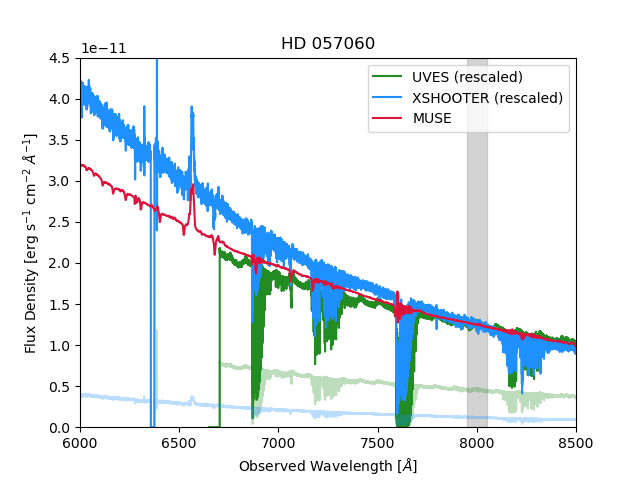

In [10]:
# Load data
# MUSE:
spectrum_muse_wave, spectrum_muse_flux, spectrum_muse_err = extract_spectrum('ADP.2020-02-26T15:36:25.254.fits',
                                                                            'MUSE', verbose=True)
# XSHOOTER
spectrum_xshooter_wave, spectrum_xshooter_flux, spectrum_xshooter_err = extract_spectrum('ADP.2017-06-02T19:41:04.876.fits',
                                                                                         'XSHOOTER', verbose=True)
# UVES
spectrum_uves_wave, spectrum_uves_flux, spectrum_uves_err = extract_spectrum('ADP.2017-10-26T20:37:15.937.fits',
                                                                                         'UVES', verbose=True)

# Rescale fluxes at ~8000Ang.
wl_norm_min, wl_norm_max = 7950., 8050.
normalization_muse = np.nanmedian(spectrum_muse_flux[(spectrum_muse_wave>wl_norm_min) & 
                                                     (spectrum_muse_wave<wl_norm_max)])
normalization_xshooter = np.nanmedian(spectrum_xshooter_flux[(spectrum_xshooter_wave>wl_norm_min) & 
                                                             (spectrum_xshooter_wave<wl_norm_max)])
normalization_uves = np.nanmedian(spectrum_uves_flux[(spectrum_uves_wave>wl_norm_min) & 
                                                     (spectrum_uves_wave<wl_norm_max)])
spectrum_xshooter_flux_rescaled = spectrum_xshooter_flux * normalization_muse / normalization_xshooter
spectrum_uves_flux_rescaled = spectrum_uves_flux * normalization_muse / normalization_uves

# Plor re-normalized spectra
plt.figure()
plt.axvspan(wl_norm_min, wl_norm_max, alpha=0.5, color='darkgrey')
plt.plot(spectrum_uves_wave, spectrum_uves_flux, c='forestgreen', alpha=0.3)
plt.plot(spectrum_uves_wave, spectrum_uves_flux_rescaled, label=r'UVES (rescaled)', c='forestgreen')
plt.plot(spectrum_xshooter_wave, spectrum_xshooter_flux, c='dodgerblue', alpha=0.3)
plt.plot(spectrum_xshooter_wave, spectrum_xshooter_flux_rescaled, label=r'XSHOOTER (rescaled)', c='dodgerblue')
plt.plot(spectrum_muse_wave, spectrum_muse_flux, label=r'MUSE', c='crimson')
plt.xlim(6000., 8500.)
plt.ylim(0., 0.45e-10)
plt.xlabel(r'Observed Wavelength [$\AA$]')
plt.ylabel(r'Flux Density [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
plt.title(r'HD 057060')
plt.legend(loc='upper right')
plt.show()
plt.savefig('HD057060.jpg', format='jpg', quality=99, bbox_inches='tight')


#### HD 172230
Cross calibrate wavelength solution to the highest resolution instrument and calculate radial velocities

<IPython.core.display.Javascript object>


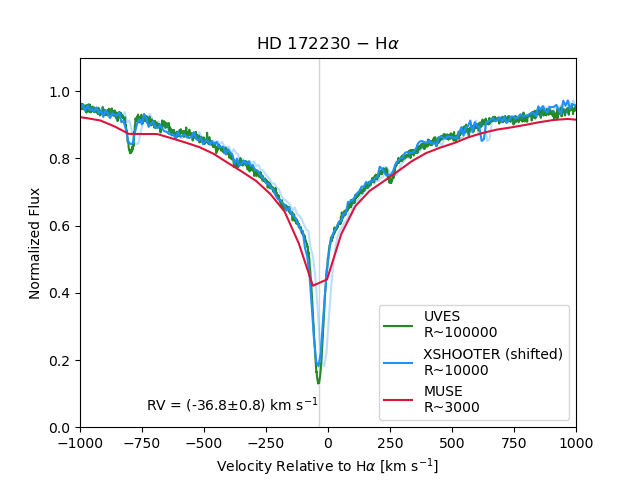

<IPython.core.display.Javascript object>


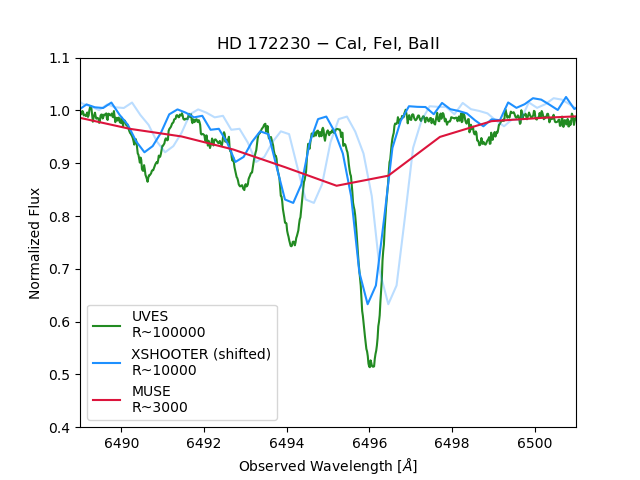

In [11]:
# Load data
# MUSE:
spectrum_muse_wave, spectrum_muse_flux, spectrum_muse_err = extract_spectrum('ADP.2020-02-26T15:36:25.276.fits',
                                                                            'MUSE')
# XSHOOTER
spectrum_xshooter_wave, spectrum_xshooter_flux, spectrum_xshooter_err = extract_spectrum('ADP.2014-05-15T16:36:52.997.fits',
                                                                                         'XSHOOTER')
# UVES
spectrum_uves_wave, spectrum_uves_flux, spectrum_uves_err = extract_spectrum('ADP.2013-09-26T23:23:35.340.fits',
                                                                                         'UVES')

# Normalize flux around H-alpha region:
wl_left_min, wl_left_max = 6423., 6428.
wl_right_min, wl_right_max = 6685., 6690.
poly_order = 1

muse_poly_mask = (( (spectrum_muse_wave>wl_left_min) & (spectrum_muse_wave<wl_left_max) ) |
                  ( (spectrum_muse_wave>wl_right_min) & (spectrum_muse_wave<wl_right_max) ))
muse_poly = np.polyfit(np.log10(spectrum_muse_wave[muse_poly_mask]), 
                       np.log10(spectrum_muse_flux[muse_poly_mask]), deg=1)
spectrum_muse_flux_normalized = spectrum_muse_flux / 10.**(np.polyval(muse_poly,
                                                                      np.log10(spectrum_muse_wave)))

xshooter_poly_mask = (( (spectrum_xshooter_wave>wl_left_min) & (spectrum_xshooter_wave<wl_left_max) ) |
                      ( (spectrum_xshooter_wave>wl_right_min) & (spectrum_xshooter_wave<wl_right_max) ))
xshooter_poly = np.polyfit(np.log10(spectrum_xshooter_wave[xshooter_poly_mask]), 
                           np.log10(spectrum_xshooter_flux[xshooter_poly_mask]), deg=1)
spectrum_xshooter_flux_normalized = spectrum_xshooter_flux / 10.**(np.polyval(xshooter_poly, 
                                                                              np.log10(spectrum_xshooter_wave)))

uves_poly_mask = (( (spectrum_uves_wave>wl_left_min) & (spectrum_uves_wave<wl_left_max) ) |
                      ( (spectrum_uves_wave>wl_right_min) & (spectrum_uves_wave<wl_right_max) ))
uves_poly = np.polyfit(np.log10(spectrum_uves_wave[uves_poly_mask]), 
                           np.log10(spectrum_uves_flux[uves_poly_mask]), deg=1)
spectrum_uves_flux_normalized =  spectrum_uves_flux / 10.**(np.polyval(uves_poly,
                                                                       np.log10(spectrum_uves_wave)))

# Plor re-normalized spectra
plt.figure()
radial_velocity = -36.80 # km/s
plt.axvspan(radial_velocity-0.8, radial_velocity+0.8, alpha=0.5, color='darkgrey')
spectrum_uves_vel = (spectrum_uves_wave/6562.793 - 1.) * 299792.458
spectrum_xshooter_vel = (spectrum_xshooter_wave/6562.793 - 1.) * 299792.458
spectrum_xshooter_vel_shifted = ((spectrum_xshooter_wave-0.5)/6562.793 - 1.) * 299792.458
spectrum_muse_vel = (spectrum_muse_wave/6562.793 - 1.) * 299792.458

plt.plot(spectrum_uves_vel, spectrum_uves_flux_normalized, label=r'UVES' + '\n' + 'R~100000', c='forestgreen')
plt.plot(spectrum_xshooter_vel, spectrum_xshooter_flux_normalized, c='dodgerblue', alpha=0.3)
plt.plot(spectrum_xshooter_vel_shifted, spectrum_xshooter_flux_normalized, label=r'XSHOOTER (shifted)' + '\n' + 'R~10000', c='dodgerblue')
plt.plot(spectrum_muse_vel, spectrum_muse_flux_normalized, label=r'MUSE' + '\n' + 'R~3000', c='crimson')
plt.xlim(-1000., 1000.)
plt.ylim(0.0, 1.1)
plt.text(radial_velocity, 0.05, r'RV = (-36.8$\pm$0.8) km s$^{-1}$', horizontalalignment='right')
plt.xlabel(r'Velocity Relative to H$\alpha$ [km s$^{-1}$]')
plt.ylabel(r'Normalized Flux')
plt.title(r'HD 172230 $-$ H$\alpha$')
plt.legend(loc='lower right')
plt.show()
plt.savefig('HD172230_6562.jpg', format='jpg', quality=99, bbox_inches='tight')

# Plor re-normalized spectra - zoom
plt.figure()
plt.plot(spectrum_uves_wave, spectrum_uves_flux_normalized, label=r'UVES' + '\n' + 'R~100000', c='forestgreen')
plt.plot(spectrum_xshooter_wave, spectrum_xshooter_flux_normalized, c='dodgerblue', alpha=0.3)
plt.plot(spectrum_xshooter_wave-0.5, spectrum_xshooter_flux_normalized, label=r'XSHOOTER (shifted)' + '\n' + 'R~10000', c='dodgerblue')
plt.plot(spectrum_muse_wave, spectrum_muse_flux_normalized, label=r'MUSE' + '\n' + 'R~3000', c='crimson')
plt.xlim(6495.-6., 6495.+6.)
plt.ylim(0.4, 1.1)
plt.xlabel(r'Observed Wavelength [$\AA$]')
plt.ylabel(r'Normalized Flux')
plt.title(r'HD 172230 $-$ CaI, FeI, BaII')
plt.legend()
plt.show()
plt.savefig('HD172230_6490.jpg', format='jpg', quality=99, bbox_inches='tight')


## All in one
The same resuls are achievable with the (un-official) ESOAsg script: [`get_data_from_radec`](https://esoasg.readthedocs.io/en/latest/archive_scripts.html#get-data-from-ra-dec)